# Unsupervised Learning Natural Language Processing

## Imports

In [2]:
from argparse import Namespace              # convenient namespace
from collections import Counter             # counting word occurance
import json                                 # for reading json file
import os                                   # file written locally
import re                                   # regular expression
import string                               # string comparison and punctuation library
from scipy.spatial.distance import cdist    # euclidean distqance
import seaborn as sns                       # visualization
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# basic array, pandas, and torch module
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

# hugging face
from transformers import DistilBertForSequenceClassification
from transformers import AutoTokenizer
from transformers import Trainer
from transformers import TrainingArguments  
from transformers import AutoModelForSequenceClassification

## Reading Data and Preprocessing
The data you provided is called "preprocessing data.csv" in the same folder as this notebook. I will rename the "body" column to "review". I will also add two new columns. One is called "split", indicating the train validation test split, with ratio of 8:1:1. The other is called "rating", which is the labels of negative, neutral, or positive. Because this is unsupervised, so this column will temporarily be randomly assigned, with ratio of 1:1:1. The data will be exported to "data.csv" in this folder.

In [3]:
data = pd.read_csv("preprocessing data.csv", parse_dates = ["date"])

data.rename(columns = {"body": "review"}, inplace = True)

data["split"] = ""
data.iloc[:int(data.shape[0] * 0.8), data.columns.get_loc("split")] = "train"
data.iloc[int(data.shape[0] * 0.8):int(data.shape[0] * 0.9), data.columns.get_loc("split")] = "val"
data.iloc[int(data.shape[0] * 0.9):, data.columns.get_loc("split")] = "test"

data["rating"] = ""
data.iloc[:int(data.shape[0] * 0.33), data.columns.get_loc("rating")] = "negative"
data.iloc[int(data.shape[0] * 0.33):int(data.shape[0] * 0.66), data.columns.get_loc("rating")] = "neutral"
data.iloc[int(data.shape[0] * 0.66): , data.columns.get_loc("rating")] = "positive"

data.to_csv("data.csv", index = False)

## Data Vectorization classes
The implementation is rather complex to explain, the interface is simple, these three classes will aid to create a json vocabulary dictionary that is stored in the model_storage folder. This dictionary contains two smaller dictionary, called "review_vocab" (the vocabulary dictionary for the review column) and "rating_vocab" (the vocabulary for the rating column). Each dictionary has three items: "token_to_idx" (the dictionary that map each token to an integer), "add_unk" (a Boolean value indicating whether to include the unknown token in the "token_to_idx"), and "unk_token" (if including the unknown token, what's the string for the unknown value).

### The Vocabulary

In [4]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

### The Vectorizer

In [5]:
class ReviewVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        """Create a collapsed one-hot vector for the review
        
        Args:
            review (str): the review 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        # Add ratings
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

### The Dataset

In [6]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            review_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of ReviewVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: ReviewClassifier
The main algorithm is cross entropy loss, classifying to three labels. Because there are sigmoid stability issue when running the cross entropy loss function, the default is to omit the sigmoid function.

In [7]:
class ReviewClassifier(nn.Module):
    """ a simple perceptron based classifier """
    def __init__(self, num_features):
        """
        Args:
            num_features (int): the size of the input feature vector
        """
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, num_features)
            apply_sigmoid (bool): a flag for the sigmoid activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch,)
        """
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

## Training Routine

### Helper functions

In [8]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### General utilities

In [9]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work
Specify that the vocabulary dictionary is called "vectorizer.json" in model_storage, also specify the data file path and the amount of epoch. Will generate the model_storage folder.

In [ ]:
args = Namespace(
    # Data and Path information
    frequency_cutoff=4,
    model_state_file='model.pth',
    review_csv='data.csv',
    save_dir='model_storage/',
    vectorizer_file='vectorizer.json',
    # No Model hyper parameters
    # Training hyper parameters
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=50,
    seed=1337,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/vectorizer.json
	model_storage/model.pth
Using CUDA: False


### Initializations
Generate the vocabulary dictionary.

In [11]:
if args.reload_from_files:
    # training from a checkpoint
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    # create dataset and vectorizer
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

Loading dataset and creating vectorizer


### Task 1 (Unsupervised learning)
I will use k mean clustering to determine three clusters of reviews. To do that, I will translate each word of an email to a one hot vector, add the sum to get the vector of each email (bag of word). Then set k to 3 and compute three clusters, corresponding to the negative, neutral, and positive.

In [12]:
with open("model_storage/vectorizer.json") as file:
    dictionary = json.load(file) ["review_vocab"] ["token_to_idx"] 

vector_realm = np.zeros( (data.shape[0], len(dictionary)), dtype = float ) # a 2D array representing the list of all vectors

for i in range(data.shape[0]):
    review = data ["review"] [i]
    vector = np.zeros(len(dictionary), dtype = float)

    for word in review.split(" "):
        if word in dictionary:
            vector [dictionary [word] ] += 1
            
    vector_realm [i] = vector

k = 3
cluster_location = vector_realm[ np.random.choice(data.shape [0], k) ] # randomly choose 3 vectors as the cluster location

# performing a while loop to find cluster is too time consuming, so I simply run a for loop of 500
for i in range(500):
    label = np.argmin( cdist(vector_realm, cluster_location), axis = 1 )
    cluster_location = np.array( [vector_realm [label == j].mean(axis = 0) for j in range(k) ] )

# after categorizing to three clusters, to determine which cluster represent which, I read some reviews, 
# and believe the second last is negative, the last is neutral, and the third last is positive.
# These three reviews are in different cluster, so each cluster represent the corresponding category.
negative = label [-2]
neutral = label [-1]
positive = label [-3]

for i in range(data.shape [0]):
    if label [i] == negative:
        data.iloc [i, data.columns.get_loc("rating")] = "negative"
    elif label [i] == neutral:
        data.iloc [i, data.columns.get_loc("rating")] = "neutral"
    else:
        data.iloc [i, data.columns.get_loc("rating")] = "positive"

def natural_language_vader_ok_categorize(string):
    categorize = SentimentIntensityAnalyzer()
    ok = categorize.polarity_scores(string)

    if (ok["compound"] >= -0.05) & (ok["compound"] <= 0.05):
        return "neutral"
    elif ok["compound"] <= -0.05:
        return "negative"
    elif ok["compound"] >= 0.05:
        return "positive"

train_categorize_list = [natural_language_vader_ok_categorize(ok) for ok in data["review"] [:int(data.shape[0] * 0.4)] ]
val_categorize_list = [natural_language_vader_ok_categorize(ok) for ok in data["review"] [int(data.shape[0] * 0.8):int(data.shape[0] * 0.85)] ]
test_categorize_list = [natural_language_vader_ok_categorize(ok) for ok in data["review"] [int(data.shape[0] * 0.9):int(data.shape[0] * 0.95)] ]
data.iloc[:int(data.shape[0] * 0.4), data.columns.get_loc("rating")] = train_categorize_list
data.iloc[int(data.shape[0] * 0.8):int(data.shape[0] * 0.85), data.columns.get_loc("rating")] = val_categorize_list
data.iloc[int(data.shape[0] * 0.9):int(data.shape[0] * 0.95), data.columns.get_loc("rating")] = test_categorize_list

# update data
data.to_csv("data.csv", index = False)
dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)

### Training loop

In [26]:
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'].float())

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/var/folders/3x/6fmb502n5r9cw2k6vpkdx7c40000gn/T/ipykernel_84291/3408865025.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_bar = tqdm_notebook(desc='training routine',


training routine:   0%|          | 0/200 [00:00<?, ?it/s]

/var/folders/3x/6fmb502n5r9cw2k6vpkdx7c40000gn/T/ipykernel_84291/3408865025.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  train_bar = tqdm_notebook(desc='split=train',


split=train:   0%|          | 0/13 [00:00<?, ?it/s]

/var/folders/3x/6fmb502n5r9cw2k6vpkdx7c40000gn/T/ipykernel_84291/3408865025.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  val_bar = tqdm_notebook(desc='split=val',


split=val:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [28]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 854.976
Test Accuracy: 42.97


<function seaborn.rcmod.reset_defaults()>

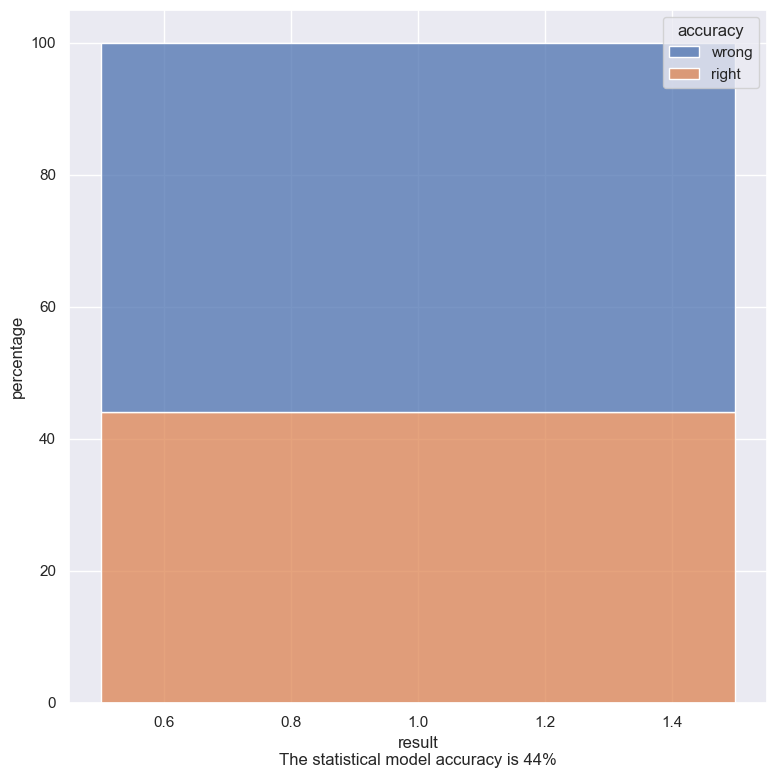

In [19]:
statistical_model_accuracy_list = []
for i in range( 100 - int(train_state['test_acc']) ):
    statistical_model_accuracy_list.append("wrong")

for i in range( int(train_state['test_acc']) ):
    statistical_model_accuracy_list.append("right")

column = []
for i in range(100):
    column.append(1)

statistical_model_accurac_table = pd.DataFrame({
    "result": column,
    "accuracy": statistical_model_accuracy_list
})

sns.set_theme(rc = {"figure.figsize": (9, 9)})
statistical_model_accuracy_graph = sns.histplot(statistical_model_accurac_table, x = "result", hue = "accuracy", multiple = "stack")
statistical_model_accuracy_graph.set_ylabel("percentage")
statistical_model_accuracy_graph.set_xlabel("result\nThe statistical model accuracy is " + str( int(train_state['test_acc']) ) + "%")
statistical_model_accuracy_graph_figure = statistical_model_accuracy_graph.get_figure() 
statistical_model_accuracy_graph_figure.savefig("Visualization/statistical model accuracy graph.jpg")
sns.reset_defaults

## Updated Statistical Model

In [20]:
del Dataset # temporarily omit PyTorch's util.data's "Dataset" module

NameError: name 'Dataset' is not defined

I would use Hugging Face's BERT statistical model. Because PyTorch's util.data's "Dataset" module has the same name as Dataset's "Dataset" moduole, I would temporarily omit PyTorch's util.data's "Dataset" module. Below is the importation of Dataset's "Dataset" moduole 

In [ ]:
from datasets import load_dataset, Split, Dataset

# Creating Hugging Face dataset. Because Hugging Face need integer labels, I will create another column
# named "labels", with negative being 1, neutral being 0, and positive being 2
data["labels"] = -1

data.loc[ data["rating"] == "neutral", "labels"] = 0
data.loc[ data["rating"] == "negative", "labels"] = 1
data.loc[ data["rating"] == "positive", "labels"] = 2

dataset_train = Dataset.from_pandas(data[ data["split"] == "train" ], split= Split.TRAIN)
dataset_test = Dataset.from_pandas(data[ data["split"] == "val" ], split = Split.TEST)

torch.manual_seed(42)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(row):
    return tokenizer(row["review"], truncation = True, padding = "max_length", max_length = 30)

dataset_train_token = dataset_train.map(tokenize, batched = True)

dataset_test_token = dataset_test.map(tokenize, batched = True)

dataset_train_token.set_format(type = "torch", columns = ["input_ids", "attention_mask", "labels"])

dataset_test_token.set_format(type = "torch", columns = ["input_ids", "attention_mask", "labels"])

# so currently I have two Hugging Face's datasets, the "dataset_train_token" and "dataset_test_token."
# Each dataset has three columns in tensor, "input_ids" stores a tensor for each sentence, the tensor stores the token for each word,
# "attention_mask" stores the sentence index of each word (so in advanced projects, people might tokenize two sentence each time,
# instead of only tokenize one sentence at a time, "attension_mask" would indicate which sentence is this word at),
# "labels" stores the label for each sentence


Map:   0%|          | 0/1752 [00:00<?, ? examples/s]

Map:   0%|          | 0/219 [00:00<?, ? examples/s]

In [22]:
# the training arguments
training_args = TrainingArguments(
    output_dir='output',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    eval_strategy='steps',
    eval_steps=300,
    logging_steps=300,
    gradient_accumulation_steps=8
)

# a function that would print accuracy
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

Make sure you have downloaded the trained natural language processing model that I have included as link in the GitHub read me. The trained natural language processing model can be imported. You can use this model directly, so that you don't have to wait to train the natural language processing model. If you prefer to train the natural language processing model, you can use the untrained natural language processing model, and please set the following Boolean to false. I do suggust that if you don't have GPU, use the trained natural language processing model. Natural language processsing training in this project may take up to 30 minutes if don't have GPU.

In [ ]:
use_the_trained_natural_language_processing_model = True

The statistical model I use is Distilt BERT, a smaller version of BERT.

In [29]:
if use_the_trained_natural_language_processing_model:
    loaded_statistical_model = AutoModelForSequenceClassification.from_pretrained("bert LLM Natural Language Processing")
    statistical_model = loaded_statistical_model
else:
    statistical_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 3)

trainer = Trainer(
    model = statistical_model,
    args = training_args,
    train_dataset = dataset_train_token,
    eval_dataset = dataset_test_token,
    compute_metrics = compute_metrics
)

if not use_the_trained_natural_language_processing_model:
    trainer.train()

result = trainer.evaluate()
accuracy = result["eval_accuracy"]
result

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.7967942357063293,
 'eval_accuracy': 0.6164383561643836,
 'eval_runtime': 24.8424,
 'eval_samples_per_second': 8.816,
 'eval_steps_per_second': 1.127,
 'epoch': 1.0}

If you haven't downloaded the trained natural language processing model, and you compute and train the natural language processing model, you can save in the folder. Set the Boolean to true. After you save the file, this file is the same as the downloaded trained natural language processing model. Next time, you can set "use the trained natural language model" as true to import.

In [ ]:
prefer_to_save_the_file_locally = False

if prefer_to_save_the_file_locally:
    trainer.save_model("bert LLM Natural Language Processing")
    os.listdir("bert LLM Natural Language Processing")

['model.safetensors', 'config.json', 'training_args.bin']

<function seaborn.rcmod.reset_defaults()>

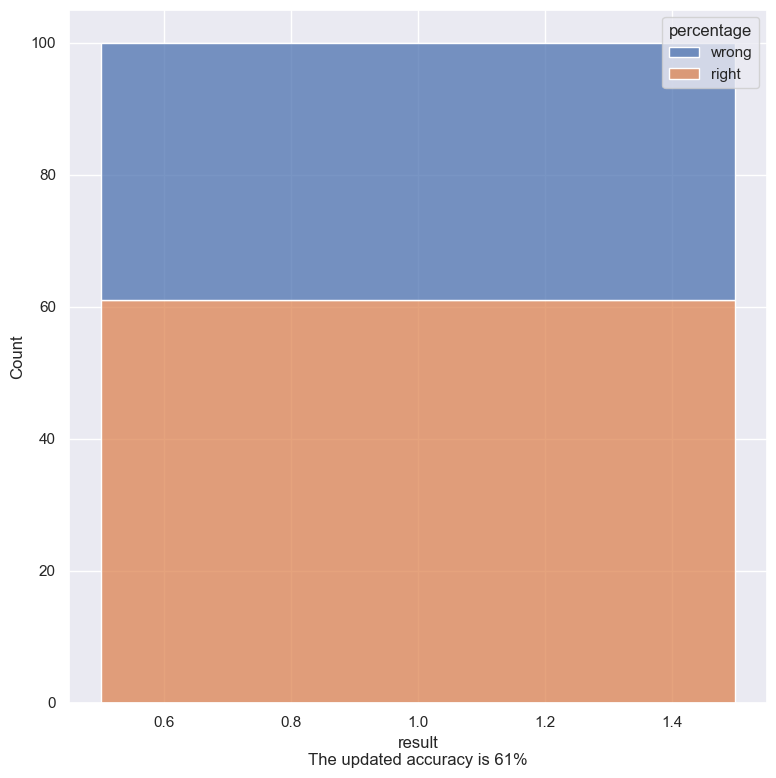

In [ ]:
updated_statistical_model_accuracy_list = []

for i in range( 100 - int(accuracy * 100)):
    updated_statistical_model_accuracy_list.append("wrong")

for i in range(int(accuracy * 100)):
    updated_statistical_model_accuracy_list.append("right")

column = []
for i in range(100):
    column.append(1)

updated_statistical_model_accuracy_table = pd.DataFrame({
    "result": column,
    "percentage": updated_statistical_model_accuracy_list
})

sns.set_theme(rc = {"figure.figsize": (9, 9)})
updated_statistical_model_accuracy_graph = sns.histplot(updated_statistical_model_accuracy_table, x = "result", hue = "percentage", multiple = "stack")
updated_statistical_model_accuracy_graph.set_xlabel("result\nThe updated accuracy is " + str( int(accuracy * 100) ) + "%")
updated_statistical_model_accuracy_graph_figure = updated_statistical_model_accuracy_graph.get_figure()
updated_statistical_model_accuracy_graph_figure.savefig("Visualization/updated statistical model accuracy graph")
sns.reset_defaults

## Task 2 (EDA)

number of rows:  2191 

Subject            object
review             object
date       datetime64[ns]
from               object
split              object
rating             object
labels              int64
month              object
dtype: object 

Subject    0
review     0
date       0
from       0
split      0
rating     0
labels     0
month      0
dtype: int64 



<function seaborn.rcmod.reset_defaults()>

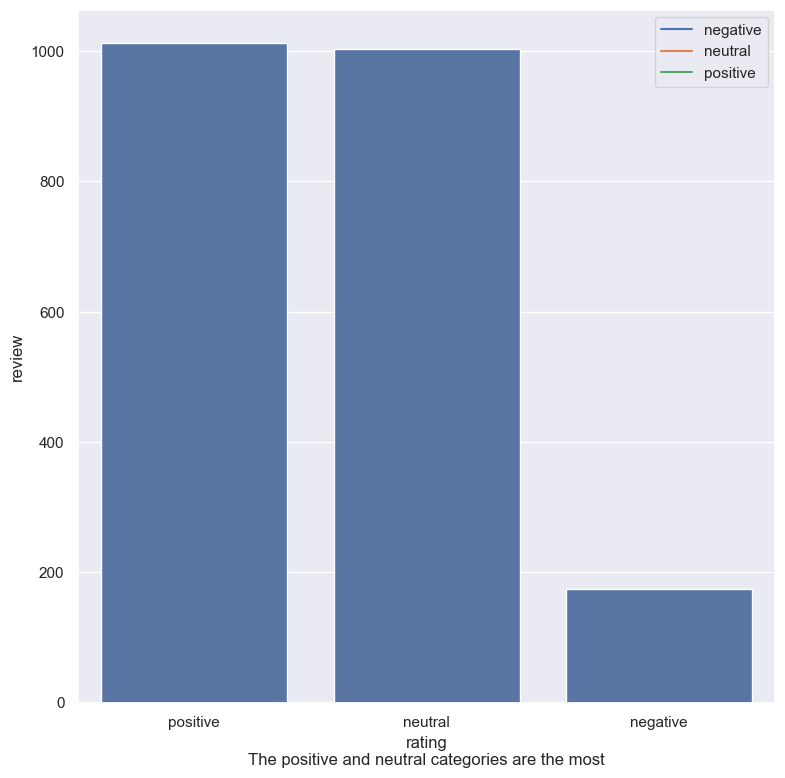

In [34]:
# overall data structure
print("number of rows: ", data.shape[0], "\n")
print(data.dtypes, "\n")
print(data.isna().sum(), "\n")

# trend
data["month"] = ""
for i in range(data.shape[0]):
    data.iloc[i, data.columns.get_loc("month") ] = pd.to_datetime( str(data["date"][i].year) + "/" + str(data["date"][i].month) + "/01")

data_category_label = data.groupby(["month", "rating"]).count()

sns.set_theme(rc = {"figure.figsize": (9, 9)})
data_category_label_graph = sns.lineplot(data_category_label, x = "month", y = "review", hue = "rating")
data_category_label_graph.set_xlabel("month\nThe positive and neutral are constantly the number 1 categories,\nall three categories are expected to stay the same for the trend")
data_category_label_figure = data_category_label_graph.get_figure()
data_category_label_figure.savefig("Visualization/rating trend.jpg")
# the positive and neutral are constantly the number 1 categories, all three categories are expected to stay the same for the trend


# distribution
label_distribution = sns.countplot(data, x = "rating")
label_distribution.set_xlabel("rating\nThe positive and neutral categories are the most abundant")
label_distribution_figure = label_distribution.get_figure()
label_distribution_figure.savefig("Visualization/label distribution.png")
sns.reset_defaults

## Task 3 (Monthly Basis Score Computation)

In [ ]:
data["monthly basis score computation"] = 0

data.iloc[data["rating"] == "negative", data.columns.get_loc("monthly basis score computation")] = -1
data.iloc[data["rating"] == "positive", data.columns.get_loc("monthly basis score computation")] = 1

monthly_basis_score_overall_series = data.groupby(["month", "from"])[ ["split", "monthly basis score computation"] ].sum().sort_values(["month", "monthly basis score computation", "from"])["monthly basis score computation"]

monthly_basis_score_overall_series

month       from                       
2010-01-01  bobette.riner@ipgdirect.com    1
            johnny.palmer@enron.com        1
            kayne.coulter@enron.com        1
            rhonda.denton@enron.com        1
            sally.beck@enron.com           1
            don.baughman@enron.com         4
            john.arnold@enron.com          4
            patti.thompson@enron.com       4
            eric.bass@enron.com            5
            lydia.delgado@enron.com        8
2010-02-01  patti.thompson@enron.com      -1
            rhonda.denton@enron.com        0
            sally.beck@enron.com           0
            lydia.delgado@enron.com        1
            kayne.coulter@enron.com        2
            eric.bass@enron.com            3
            don.baughman@enron.com         4
            john.arnold@enron.com          5
            bobette.riner@ipgdirect.com    6
            johnny.palmer@enron.com        7
Name: monthly basis score computation, dtype: int64

## Task 4 (Monthly Basis Score Series)

In [39]:
month_list = []
positive_list = []
overall_score_basis_1 = []
negative_list = []
overall_score_basis_2 = []
for i in pd.Series(data["month"].unique()).sort_values():
    for j in range(3):
        month_list.append(i) 
        positive_list.append(monthly_basis_score_overall_series[i].sort_values(ascending = False).index[j])
        overall_score_basis_1.append(monthly_basis_score_overall_series[i].sort_values(ascending = False).iloc[j])
        negative_list.append(monthly_basis_score_overall_series[i].sort_values().index[j])
        overall_score_basis_2.append(monthly_basis_score_overall_series[i].sort_values().iloc[j])


monthly_basis_score_series = pd.DataFrame({
    "month": month_list,
    "positive": positive_list,
    "overall score basis 1": overall_score_basis_1,
    "negative": negative_list,
    "overall score basis 2": overall_score_basis_2
})

monthly_basis_score_series.to_csv("Visualization/monthly basis score series.csv", index = False)

monthly_basis_score_series

month                     positive  overall score basis 1  \
0  2010-01-01      lydia.delgado@enron.com                      8   
1  2010-01-01          eric.bass@enron.com                      5   
2  2010-01-01       don.baughman@enron.com                      4   
3  2010-02-01      johnny.palmer@enron.com                      7   
4  2010-02-01  bobette.riner@ipgdirect.com                      6   
..        ...                          ...                    ...   
67 2011-11-01         sally.beck@enron.com                      5   
68 2011-11-01  bobette.riner@ipgdirect.com                      4   
69 2011-12-01          eric.bass@enron.com                      8   
70 2011-12-01      kayne.coulter@enron.com                      6   
71 2011-12-01      lydia.delgado@enron.com                      6   

                       negative  overall score basis 2  
0   bobette.riner@ipgdirect.com                      1  
1       johnny.palmer@enron.com                      1  
2       kayne.coulter@enron.com                      1  
3      patti.thompson@enron.com                     -1  
4       rhonda.denton@enron.com                      0  
..                          ...                    ...  
67          eric.bass@enron.com                      1  
68      johnny.palmer@enron.com                      3  
69  bobette.riner@ipgdirect.com                      1  
70      johnny.palmer@enron.com                      1  
71        john.arnold@enron.com                      3  

[72 rows x 5 columns]

## Task 5 (Past 30 Days)

In [ ]:
input_date = pd.to_datetime("2010/03/01") # specify the input date (default to 03/01/2010)
data[ (data["date"] >= input_date - pd.Timedelta(days = 30)) & (data["date"] <= input_date) & (data["monthly basis score computation"] == -1) ].groupby("from")["monthly basis score computation"].sum().loc[lambda x: x <= -4] 

Series([], Name: monthly basis score computation, dtype: int64)

## Task 6 (Prediction)
The algorithm is to utilize the classifier as well as the sigmoid function to compute a scalar for each review. Then compute the average value for negative, neutral, and positive review. When classifying a new string, simply compute the absolute value with the three average value and choose the nearest category.

In [42]:
# lowercase and omit the punctuation
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [ ]:
# list that store the sigmoid value for each rating
index_0 = []
index_1 = []
index_2 = []

for i in range(data[ data["split"] == "train" ].shape[0]):
    ok = preprocess_text(data[ data["split"] == "train" ]["review"][i]) 
    vectorized_review = torch.tensor(vectorizer.vectorize(ok))
    result = classifier(vectorized_review.view(1, -1))
    sigmoid_value = F.sigmoid(result).item()
    if data["rating"][i] == "negative":
        index_0.append(sigmoid_value)
    elif data["rating"][i] == "neutral":
        index_1.append(sigmoid_value)
    else:
        index_2.append(sigmoid_value)

average_negative_sigmoid_value = np.average(index_0)
average_neutral_sigmoid_value = np.average(index_1)
average_positive_sigmoid_value = np.average(index_2)

In [44]:
print(average_negative_sigmoid_value)
print(average_neutral_sigmoid_value)
print(average_positive_sigmoid_value)

0.5060023316677581
0.5411481987544211
0.5752967053265146


In [45]:
# the classification function
def predict_rating(review, classifier, vectorizer):
    """Predict the rating of a review
    
    Args:
        review (str): the text of the review
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    sigmoid_value = F.sigmoid(result).item()
    
    sigmoid_negative_distance = abs(sigmoid_value - average_negative_sigmoid_value)
    sigmoid_neutral_distance = abs(sigmoid_value - average_neutral_sigmoid_value)
    sigmoid_positive_distance = abs(sigmoid_value - average_positive_sigmoid_value)

    if sigmoid_neutral_distance < sigmoid_negative_distance and sigmoid_neutral_distance < sigmoid_positive_distance:
        index = 1
    elif sigmoid_negative_distance < sigmoid_positive_distance:
        index = 0
    else:
        index = 2

    return vectorizer.rating_vocab.lookup_index(index)

In [58]:
test_review = "hello, how are you doing"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer)
print("{} -> {}".format(test_review, prediction))

hello, how are you doing -> neutral


## Updated Prediction

In [57]:
test_review = "hello, how are you doing"

tokens = tokenizer(test_review, return_tensors = "pt")

statistical_model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

statistical_model.to(device)

def predict_tokens(tokens):
    logit = statistical_model(input_ids = tokens["input_ids"], attention_mask = tokens['attention_mask']).logits.argmax(dim = 1)
    if logit == 0:
        print("neutral")
    elif logit == 1:
        print("negative")
    else:
        print("positive")

predict_tokens(tokens)

neutral


### End